Importing libraries

In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pybammeis
import pybamm
from utils.load_data import get_exp_data
from utils.parameters import params 
params = params()
from utils.potential_gradient import _dU_dc_anode
from utils.check_SOC import get_vdc
from utils.convertion import dict_to_list, list_to_dict
from utils.ecm_randles import calc_randles_Z, a_randles
from utils.ecm_meyers import calc_meyers_Z, a_meyers
from utils.ecm_meyers_K import calc_meyers_K_Z, a_meyers_K
from utils.ecm_meyers_all_params import calc_meyers_all_Z, a_meyers_all
from utils.optimize import optimize_diff
from utils.optimize_from_Randles import optimize_randles 
from utils.optimizing_plot import optimizing_plot
from utils.changes_in_params_plot import plot_change_param
from utils.experimental_plot import plotting, combined_plot
from utils.all_sets_plot import plot_all_sets
from utils.pso import pso 
from utils.load_cycling_data import read_csv, read_txt
from utils.cycling_plot import plot_cycling
from utils.pybamm_plot import pybamm_plotting
from utils.Bode_plot import plot_impedance


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Calculate impedance (from Meyers paper)

$$R_{part} = \left(-\frac{\partial U}{\partial c_s}\right)\frac{R_s}{FD_s}$$

$$Y_s = \frac{\sqrt{j\Omega_s}-\tanh(\sqrt{j\Omega_s})}{\tanh(\sqrt{j\Omega_s})},$$

where $Y_s$ is the admittance for the diffusion effect and $\Omega_s$ is the dimensionless frequency: 

$$\Omega_s = \frac{\omega R_s^2}{D_s^{a}}$$

Further, 

$$Y(\omega) = \frac{1}{\frac{R1 + \frac{R_{part}}{Y_s}}{1 + j\omega C1\left(R1 + \frac{R_{part}}{Y_s}\right)} + \frac{R2}{1+j\omega R2\cdot C2}}, $$

where $Y(\omega)$ is the admittance (intercalation, BV-kinetics and double-layer capacitance) of a single particle at a given frequency. $\overline{aY}$ is the average admittance in the porous electrode. 

$$v = \frac{L}{\left(\frac{K\sigma}{K + \sigma}\right)^{\frac{1}{2}}\left({\overline{aY}}\right)^{-\frac{1}{2}}}, $$

where the parameter $v$ is a function of frequency $\omega$ and is determined for set values of $\sigma$ and $K$. 
Finally, the total impedance is given by

$$Z = \frac{L}{K+\sigma}\left[1 + \frac{2 + (\frac{\sigma}{K} + \frac{K}{\sigma})\cosh v}{v\cdot \sinh v}\right]$$




### Meyers parameters

+ $R1$ - resistance 
+ $R2$ - resistance 
+ $C1$ - capicitance 
+ $C2$ - capicitance 
+ $R_s$ - particle size (assuming radius)
+ $D_s$ - diffusion coefficient 
+ $a$ - surface area of pores per volume electrode
+ $L$ - electrode thickness
+ $K$ - electrolyte conductivity 
+ $\sigma$ - electrode conductivity 
+ $\epsilon$ - porosity 
+ $\left(-\frac{\partial U}{\partial c_s}\right)$

These parameters are defined from the given parameters by Amund (in the utils folder: parameters). If the Meyer parameter does not have an equivalent in the parameter list above, it is calculated from relations (for example, the resistances $R1$ and $R2$ are calculated from the exhange current density $i$). 


### Calculating the Meyers parameters which are not defined in the given parameter list:

In [2]:
F = 96485 #C/mol 
R = 8.314 #J/mol*K
n = 1 
T = 298 # K

c_n_max = params["Maximum concentration in negative electrode [mol.m-3]"]
c_n_s_max = c_n_max 
c_p_max = params["Maximum concentration in positive electrode [mol.m-3]"]
c_p_s_max = c_p_max

params.set_initial_stoichiometries(0.45) # Setting SOC, this changes the initial concentrations
c_n = params['Initial concentration in negative electrode [mol.m-3]'] 
c_n_s = c_n # for the surface of the particle
c_p = params['Initial concentration in positive electrode [mol.m-3]'] 
c_p_s = c_p

volume_anode = params['Electrode height [m]']*params['Electrode width [m]']*params['Negative electrode thickness [m]'] # [m^3]
volume_cathode = params['Electrode height [m]']*params['Electrode width [m]']*params['Positive electrode thickness [m]'] # [m^3]
area_electrode = params['Electrode height [m]']*params['Electrode width [m]'] #[m^2]

c_e = params['EC initial concentration in electrolyte [mol.m-3]']
i_0_a = params['Negative electrode exchange-current density [A.m-2]'](c_e, c_n_s, c_n_s_max, T)
i_0_c = params['Positive electrode exchange-current density [A.m-2]'](c_e, c_p_s, c_p_s_max, T)

r_a = params['Negative particle radius [m]']
r_c = params['Positive particle radius [m]']
e_a = 1 - params['Negative electrode porosity']
e_c = 1 - params['Positive electrode porosity']



#### Equation for finding $R_{ct}$ from the given exchange current density parameter: 

The charge transfer resistances (= $R_{ct}$), $R1$ and $R2$, are found from the Butler-Volmer equation: 

$$R_{ct} = \frac{RT}{n\cdot i_0(\alpha_a + \alpha_c)F}, $$

at small overpotentials and assuming a symmetrical charge transfer process $(\alpha_a + \alpha_c = 1)$. This equation is also written as equation $(20)$ in the Meyers paper. 

In [3]:

def R_ct(i_0): 
    return (R*T)/(n*F*i_0) # [ohm.m^2]

R1_a = R_ct(i_0_a).__dict__['_value']
R1_c = R_ct(i_0_c).__dict__['_value']


####  Equation for finding the pore surface volume divided by the electrode volume (=$a$):

The pore surface area can be found from the following calculations: 

$$V_{particle} = \frac{4\pi r^3}{3}$$
$$V_{active} = \epsilon \cdot V_{electrode}, $$

where $\epsilon$ is the fraction of active electrode material and then $V_{active}$ is the volume of the active electrode material. This gives the number of particles $N = \frac{V_{active}}{V_{particle}}$. Further, the surface area of one particle is 

$$A_{particle} = 4 \pi r^2, $$

so that $A_{total} = N\cdot A_{particle}$, where $A_{total}$ is the total pore/particle surface area. 

Then $a$ is calculated from 

$$a = \frac{A_{total}}{V_{electrode}}$$




In [4]:

N = e_a*volume_anode/((4*np.pi/3)*r_a**3)

def a(V_electrode, e): 
    V_particle = (4*np.pi/3)*r_a**3
    V_active = e*V_electrode 
    # Number of particles
    N = V_active/V_particle 
    # Surface area of particle 
    A_particle = 4*np.pi*r_a**2
    # Total surface area of particles
    A_total = N*A_particle # so that A_total = (3*e)/r_particle
    return A_total/V_electrode # [m^-1]


### The resulting Meyers parameter set 

In [5]:

a_parametre = { 
    "R1": R1_a,  # motstand, [ohm.m^2]
    "C1": params['Negative electrode double-layer capacity [F.m-2]'],  # kapasitans
    "Rs": params['Negative particle radius [m]'], # partikkelstørrelse, [F.m^-2]
    "Ds": params['Negative electrode diffusivity [m2.s-1]'],     # diffusjonskoeffisient [m^2.s^-1]
    "a": a(volume_anode, e_a),  # overflateareal porer/volum electrode [m^-1]
    "L": params['Negative electrode thickness [m]'],  # tykkelse, elektrode, [m]
    "K" : params['Electrolyte conductivity [S.m-1]'](c_e, T),  # ledningsevne elektrolytt [S.m^-1]
    "sigma": params['Negative electrode conductivity [S.m-1]'], # ledningsevne, fast elektrodematerial [S.m^-1]
    "ebsilon": e_a,     # volume fraction anode
    "-dU_dcs": _dU_dc_anode(c_n), #[V.m^3.mol-1]
    }


Comparing with experimental data, this does not fit. The further step is then to optimize the parameters. 

# Dataset 1: Fitting parameters to experimental data

In general, R1, R2, C1, C2, Ds and a are the parameters which will be fitted. The rest of the Meyers parameters are assumed correct and constant. 
The changes are done in the following parameter sets: 
+ "a_meyers": An electrolyte resistance is added to move the simulated plot to the experimental 
+ "a_meyers_K": The electrolyte konductivity is also added
+ "a_meyers_all": All parameters are optimized, plus an inductance term to modify the semicircle. 

Since the scipy optimization works on the Randles ECM (and not on the Meyers ECM), I have suspected that the Meyers model does not properly fit the experimental data. To investigate this, I made a new optimization code named "optimize_randles", which optimizes the meyers parameters to the optimized Randles graph (since the optimized Randles graph is smoother than the experimental data)! As seen in the difference between the last and the above last plot below, my suspicions were true, as interpreted by the shape of the scipy optmized graph in green. 

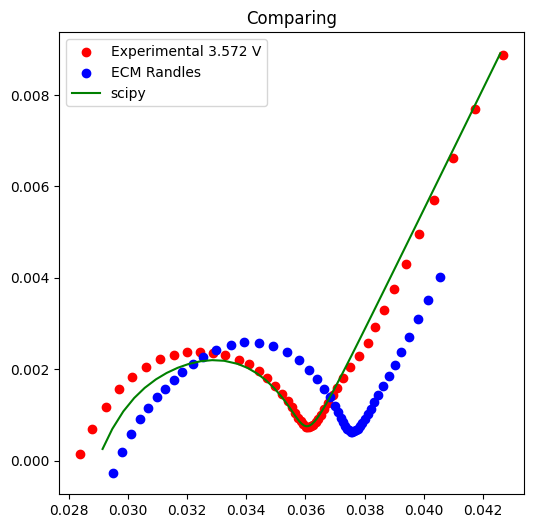

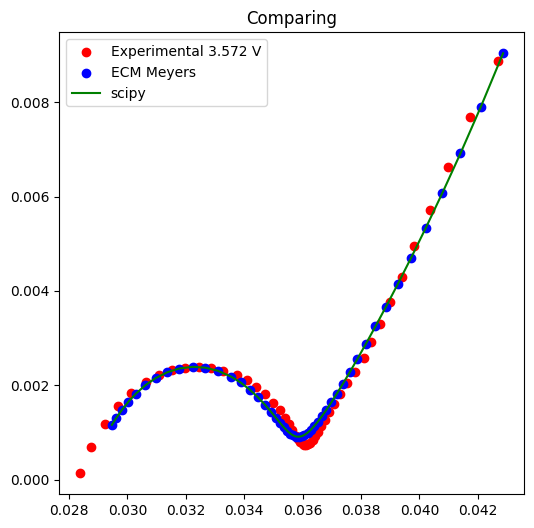

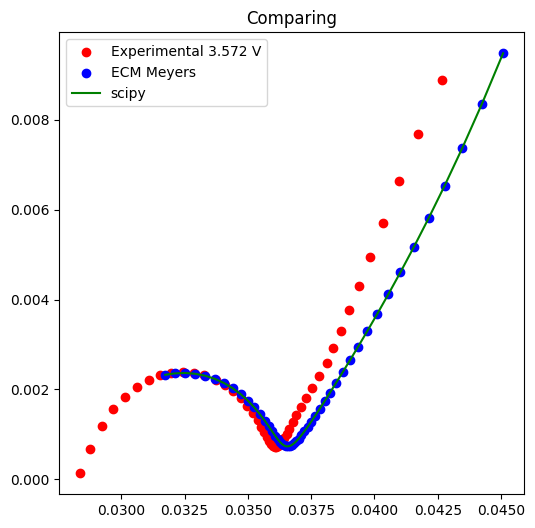

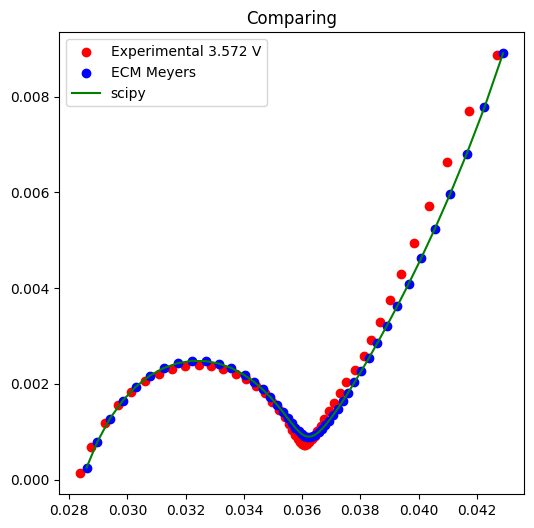

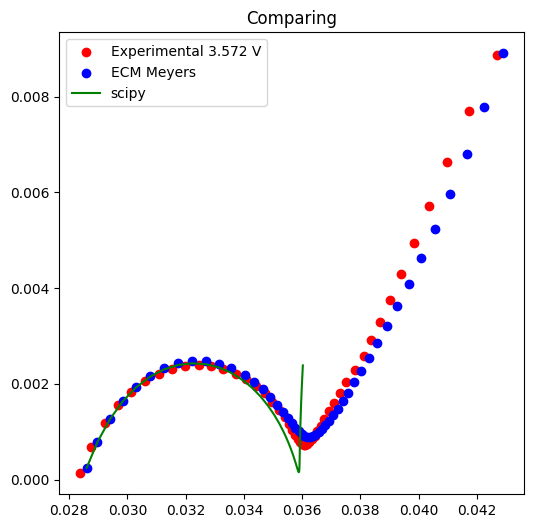

In [43]:
# From difference function 
optimizing_plot(1, "Randles", a_randles, calc_randles_Z, optimize_diff)

optimizing_plot(1, "Meyers", a_meyers, calc_meyers_Z, optimize_diff)
optimizing_plot(1, "Meyers", a_meyers_K, calc_meyers_K_Z, optimize_diff)
optimizing_plot(1, "Meyers", a_meyers_all, calc_meyers_all_Z, optimize_diff)
optimizing_plot(1, "Meyers", a_meyers_all, calc_meyers_all_Z, optimize_randles)

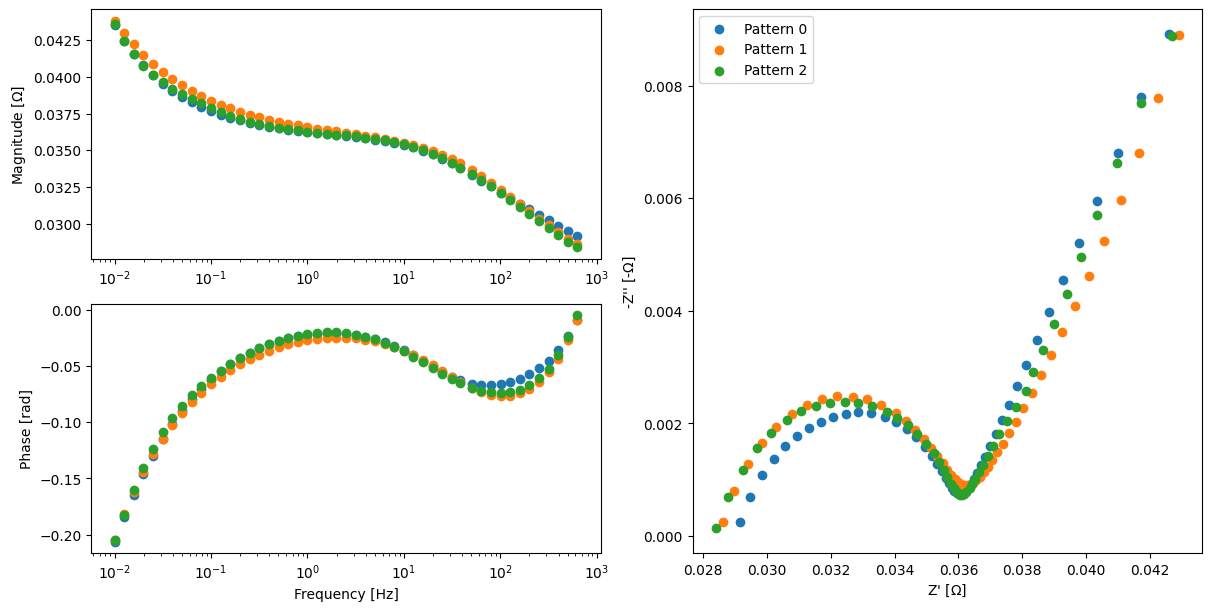

In [44]:
i = 1
freq = np.array(get_exp_data(i, "")[1])
exp_real = np.array(get_exp_data(i, "")[0][0])
exp_imag = np.array(get_exp_data(i, "")[0][1])

Z_exp = exp_real + exp_imag*1j

final_diff, opt_randles_param = optimize_diff(i, a_randles, calc_randles_Z)
Z_randles_opt = calc_randles_Z(opt_randles_param, freq)

plot_impedance([(freq, Z_randles_opt), 
                (freq, calc_meyers_all_Z(dict_to_list(a_meyers_all), freq)),
                (freq, Z_exp)])

#### We can also observe how a given parameter changes for each data set (degradation step)

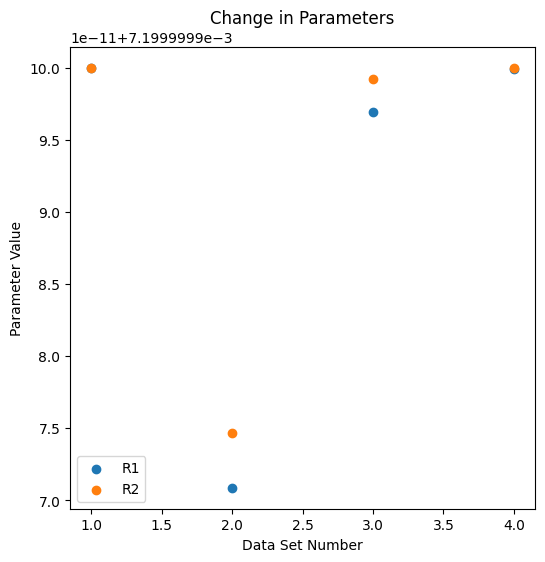

In [7]:

plot_change_param(['R1', 'R2'], a_meyers_all, calc_meyers_all_Z, optimize_randles)

## Plotting the C/5 cycling data to confirm amount of degradation

$ R = \frac{\Delta U}{\Delta I}$ in the cycling plot, which should correspond to the amount of change in resistance in the Nyquist plots. 

In [8]:
MJ12s = {
    "MJ12_01": read_txt('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_01.015.txt'), 
    "MJ12_02": read_txt('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_02.016.txt'),
    "MJ12_03": read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_03 - 010.csv'), 
    "MJ12_04": read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_04 - 010.csv'), 
    "MJ12_05": read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_05 - 016.csv')
}

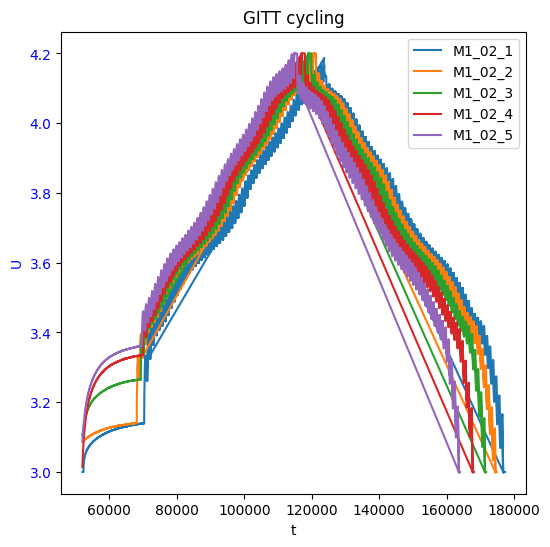

the increase in resistance from data set 1 to 2, and 2 to 3 etc., is [0.10436137071651047, 0.004672897196261859, 0.02024922118380047, 0.04672897196261721]


In [9]:
plot_cycling(dict_to_list(MJ12s))

Here, I have used the GITT charging cycle where the first data set is at $45 \%$ SOC, namely $U = 3.587 V$. 
Then I have calculated $R_{change} = \frac{\Delta U}{I}$ since we have a constant current! 

# Generating EIS simulation

Assumptions:
- DFN model
- same parameters as I got from Amund
- input parameter SoC - 45% 
- at 25 degrees C
- using the numerical prebicgstab frequency domain method 

Using the same frequency range as the frequency range in teh experimental data sets. 

In [10]:
# Changing state of charge SOC
z = 0.45

x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(params)
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = params["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = params["Maximum concentration in positive electrode [mol.m-3]"]

params.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

# Choosing the same frequency range as in the experimental plot. 
frequencies = np.array(get_exp_data(1, "")[1])

Plotting the simulation: 

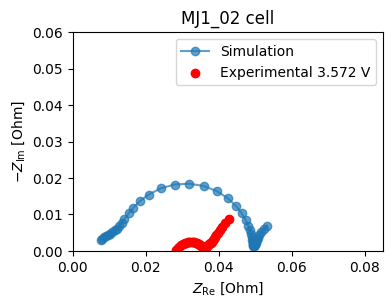

In [11]:
pybamm_plotting(1, params, 0, [0, 0.085], [0, 0.06])

As seen, the Pybamm simulation does not fit with the experimental graph. Further, I am finding the "correct" Pybamm parameters from the optimized Randles circuit!

In [12]:
# The optimized Randles parameters
final_diff, opt_randles = optimize_diff(1, a_randles, calc_randles_Z)
opt_elems = list_to_dict(a_randles, opt_randles)

# geometry parameters
e_height = params['Electrode height [m]'] 
e_width = params['Electrode width [m]'] 
e_A = e_height*e_width
s_thick = params['Separator thickness [m]'] 
anode_thick = params['Negative electrode thickness [m]'] 
cathode_thick = params['Positive electrode thickness [m]'] 

R = 8.314
T = 298
F = 96485
z = 1


Electrolyte conductivity from Nernst-Einstein: 

$$ K = \frac{z^2F^2cD}{RT}, $$

where $D$ = diffusivity of ions in $[m^2s^{-1}]$. To express $D$ with the electrolyte resistance, $K$ is substituted by an expression derived from Ohms law: 

$$ K = \frac{L}{RA} $$

This gives that 

$$ D = \frac{RTL}{z^2F^2cAR}, $$ 

where $L$ = electrolyte "thickness" and $A$ = cross-sectional area of the electrolyte. 



In [13]:

# Parameters I want to change to optimize the simulation graph: 
p = {
    #Capacity - analog to Cdl/CPE in the Randles circuit 
    'Negative electrode double-layer capacity [F.m-2]': opt_elems.get('Q2')/e_A, 
    'Positive electrode double-layer capacity [F.m-2]': opt_elems.get('Q1')/e_A, 

    #Exchange current density - relation to Rct in the Randles circuit through the Butler-Volmer 
    "Positive electrode exchange-current density [A.m-2]": (R*T)/(z*F*opt_elems.get('R_ct1')), 
    "Negative electrode exchange-current density [A.m-2]": (R*T)/(z*F*opt_elems.get('R_ct2')), 

    #Omic resistance - analog to Rel in the Randles circuit 
    "Electrolyte conductivity [S.m-1]": 1/(s_thick*opt_elems.get('R_el')), #function 
    "Negative electrode conductivity [S.m-1]": anode_thick/(opt_elems.get('R_ct2')*e_A),  
    "Positive electrode conductivity [S.m-1]": cathode_thick/(opt_elems.get('R_ct1')*e_A), 

    #Mass transfer resistance - analog to W in the Randles circuit? 
    #"Negative particle diffusivity [m2.s-1]": ((R*T)/(z*F*e_A*opt_elems.get('A1')))**2, 
    #"Electrolyte diffusivity [m2.s-1]": (R*T*s_thick)/(z**2*F**2*c_n*e_A*opt_elems.get('R_el')),  
     }

Updating the parameter dictionary: 

In [14]:
init_params = dict_to_list(p)

# New parameter list 
params_new = params
params_new.update(
    {'Negative electrode double-layer capacity [F.m-2]': init_params[0], 
     'Positive electrode double-layer capacity [F.m-2]': init_params[1], 

     "Positive electrode exchange-current density [A.m-2]": init_params[2], 
     "Negative electrode exchange-current density [A.m-2]": init_params[3], 

     "Electrolyte conductivity [S.m-1]": init_params[4], 
     "Negative electrode conductivity [S.m-1]": init_params[5], 
     "Positive electrode conductivity [S.m-1]": init_params[6], 

     #"Negative particle diffusivity [m2.s-1]": init_params[7],
     #"Electrolyte diffusivity [m2.s-1]": init_params[8]

     })

Jeg legger også på en elektrolyttresistans (under: 0.03 Ohm) for å flytte den simulerte grafen nærmere den eksperimentelle. 

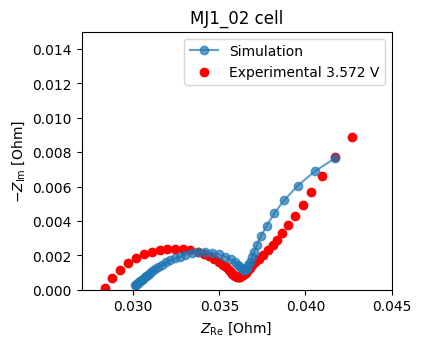

In [15]:
pybamm_plotting(1, params_new, 0.03, [0.027, 0.045], [0, 0.015])